# Detection & Compare

對比別人已經做好的 spike train

reference https://zenodo.org/record/1413593#.YBjhgS3RZhG


In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# Read data
fullpath = os.path.join('/','home','jovyan','indy','The_nwb_Raw_Dataset','indy_20170124_01.nwb')
f = h5py.File(fullpath, 'r')
data = f['/acquisition/timeseries/broadband/data']
conversion = data.attrs['conversion']
timestamps = f['/acquisition/timeseries/broadband/timestamps']

In [3]:
fs = 24414.0625 
dur = 1
start = 100
channel = 96
signal_length = (int) (dur * fs)

# index_of_begin and index_of_end
ib = (int) (start * fs)
ie = ib + signal_length
ch1 = data[ib:ie].T[1-1]
t = timestamps[ib:ie]
# time_of_begin and time_of_end
tb = min(t)
te = max(t)


In [4]:
#https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='highpass')
    return b, a

def butter_highpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_highpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y



In [5]:
ch1 = np.array(ch1)
t = np.array(t)
cutoff_lp = 5000.0
cutoff_hp = 500.0
temp = butter_lowpass_filter(ch1, cutoff_lp, fs/2)
ch1_after = butter_highpass_filter(temp, cutoff_hp, fs/2 )


In [6]:
Thr = 3.5 * np.std(np.abs(ch1_after))
print(Thr)
#ch1_spike = np.sort(np.append(t[ch1_after > Thr], t[ch1_after < -Thr]))
ch1_spike = np.sort(t[ch1_after < -Thr])
print(len(ch1_spike))
print(ch1_spike)


65.3599212706
444
[ 1498.00108451  1498.00112547  1498.00116643  1498.00120739  1498.00235426
  1498.01709971  1498.01927056  1498.01931152  1498.01935248  1498.02021263
  1498.02025359  1498.02115471  1498.03598208  1498.03602304  1498.03606399
  1498.04024187  1498.04028283  1498.04052859  1498.04151162  1498.04155258
  1498.04339576  1498.04822899  1498.04826995  1498.04896626  1498.04900722
  1498.04904818  1498.04908914  1498.05347182  1498.05351278  1498.05355374
  1498.06256485  1498.07116636  1498.07120732  1498.07124828  1498.07128924
  1498.07395161  1498.07399257  1498.07403353  1498.07407449  1498.07411545
  1498.07415641  1498.07419737  1498.07571287  1498.08210257  1498.08779595
  1498.08783691  1498.08787787  1498.08947529  1498.09176903  1498.09451332
  1498.09455428  1498.09459524  1498.09991999  1498.09996095  1498.10000191
  1498.10004287  1498.10008383  1498.10012479  1498.10016575  1498.10020671
  1498.10745655  1498.10749751  1498.11749165  1498.11753261  1498.131

In [7]:
fullpath = os.path.join('/','home','jovyan','indy','Sorted_Spike_Dataset','indy_20170124_01.mat')
f = h5py.File(fullpath, 'r')
temp = np.array([])
for i in range(len(f['spikes'])):
    temp = np.append(temp, np.array(f[f['spikes'][i][0]]))
temp = np.sort(temp)
temp = temp[temp > tb]
temp = temp[temp < te]
ch1_spike_markin = temp
print(len(ch1_spike_markin))
print(ch1_spike_markin)

19
[ 1498.0196392   1498.04552566  1498.10045246  1498.1640627   1498.68068596
  1498.7263559   1498.74011832  1498.74728624  1498.75674791  1498.78623881
  1498.83530839  1498.85443652  1498.88515621  1498.89658394  1498.9120257
  1498.92947448  1498.95400928  1498.97977285  1498.99541942]


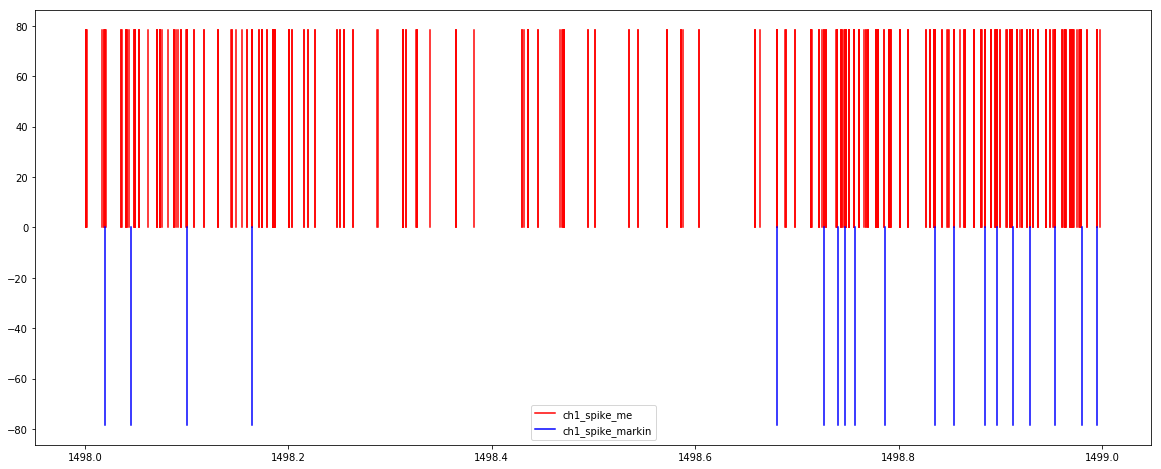

In [8]:
plt.figure(figsize=(20, 8))

for it in ch1_spike:
    plt.plot([it, it], [0, Thr*1.2], 'r')
plt.plot([it], [0], 'r', label='ch1_spike_me')
for it in ch1_spike_markin:
    plt.plot([it, it], [0, -Thr*1.2], 'b')  
plt.plot([it], [0], 'b', label='ch1_spike_markin') 
plt.legend()
plt.show()